### Задача:

1. Воспроизведите график числа рекламных событий по дням. 

2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло. 

З*. Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? 
Предложите вариант кода, который решает эту задачу. Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики. 

Немного дополнительной информации о структуре рекламы ВКонтакте. Есть две основные группы рекламодателей: агентства и клиенты. Агентствами являются рекламные кабинеты юридических лиц. Среди клиентов же существуют как клиенты этих самых агентств, так и автономные рекламные кабинеты физических лиц, над которыми нет агентств. Рекламные кампании — это наборы рекламных объявлений. Они есть в каждом кабинете. 

### Описание данных:

time — время взаимодействия пользователя с рекламой в формате UnixTime;
event — тип взаимодействия (click — клик на объявление, view — показ объявления, report — жалоба на объявление);
ad_cost_type — тип трат рекламного объявления (CPM — траты за 1000 показов, CPC — траты за клик);
has_video — наличие видео в объявлении (0 — нет, 1 — есть);
agency_union_id — id рекламного агентства (если рекламный кабинет принадлежит физическому лицу, то ячейка будет заполнена значением 'no_agency');
client_union_id — id рекламного клиента;
campaign_union_id — id рекламной кампании;
ad_id — id рекламного объявления;
platform — платформа, с которой пользователь взаимодействовал с рекламой (web — веб-версия, mvk — мобильная версия, iphone — IOS-приложение, android — Android-приложение, wphone — Windows Phone-приложение).

### Решение 1 части задания

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('test_data.csv', sep = ',')

Переведем время в формат pandas

In [3]:
data['time'] = pd.to_datetime(data['time'], unit = 's')

In [4]:
data.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,2019-04-08 17:22:25,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,2019-04-12 21:10:58,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,2019-04-16 08:16:41,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,2019-04-09 15:07:59,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,2019-04-11 07:11:57,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


In [5]:
data.shape

(122097, 10)

In [6]:
for_plot = data['event'].groupby(by = data['time'].dt.date).count()

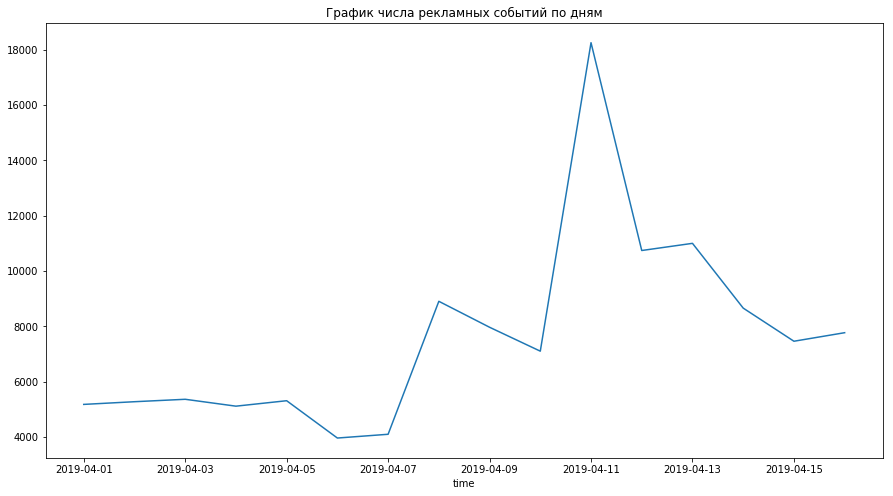

In [7]:
plt.figure(figsize = (15, 8))
plt.title('График числа рекламных событий по дням')
sns.lineplot(x = for_plot.index, y = for_plot.values)

### Решение второй части задания

Проверим типы взаимодействий (возможно, аномалия кроется здесь)

In [8]:
data_click = data[data['event'] == 'click']['event'].groupby(by = data['time'].dt.date).count()
data_view = data[data['event'] == 'view']['event'].groupby(by = data['time'].dt.date).count()
data_report = data[data['event'] == 'report']['event'].groupby(by = data['time'].dt.date).count()

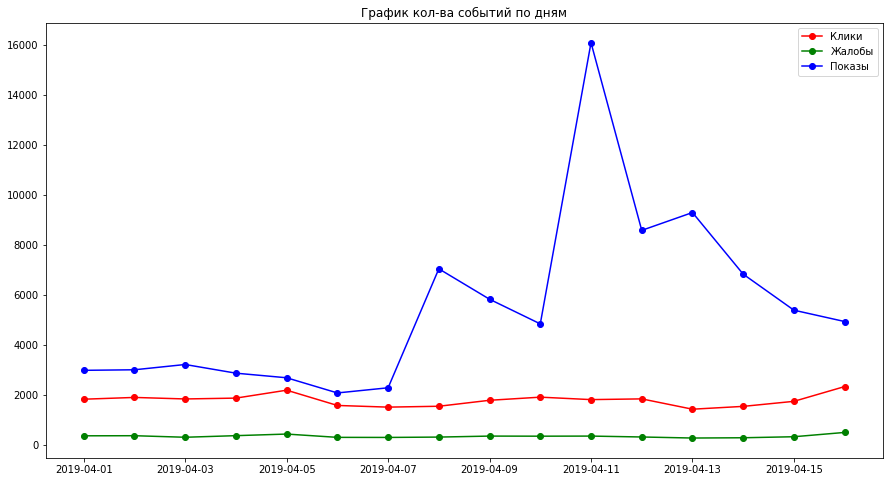

In [9]:
plt.figure(figsize = (15, 8))
plt.title('График кол-ва событий по дням')
plt.plot_date(x = data_click.index, y = data_click.values, color = 'red', linestyle = '-', label = 'Клики')
plt.plot_date(x = data_click.index, y = data_report.values, color = 'green', linestyle = '-', label = 'Жалобы')
plt.plot_date(x = data_click.index, y = data_view.values, color = 'blue', linestyle = '-', label = 'Показы')
plt.legend()

Значит, дело в показах, аномалия хорошо заметна. Давайте анализировать их.

In [10]:
data_view_0411 = data[(data['time'] >= '2019-04-11 00:00:00') & (data['time'] < '2019-04-12 00:00:00') &  (data['event'] == 'view')]

In [11]:
by_hour = data_view_0411.groupby(by = data_view_0411['time'].dt.hour)['event'].count()

In [12]:
by_hour

time
0       73
1       26
2       18
3       26
4       43
5       64
6      125
7      166
8      229
9      466
10    1733
11    1876
12    1690
13    1520
14    1426
15    1195
16     749
17     699
18     749
19     722
20     732
21     719
22     611
23     440
Name: event, dtype: int64

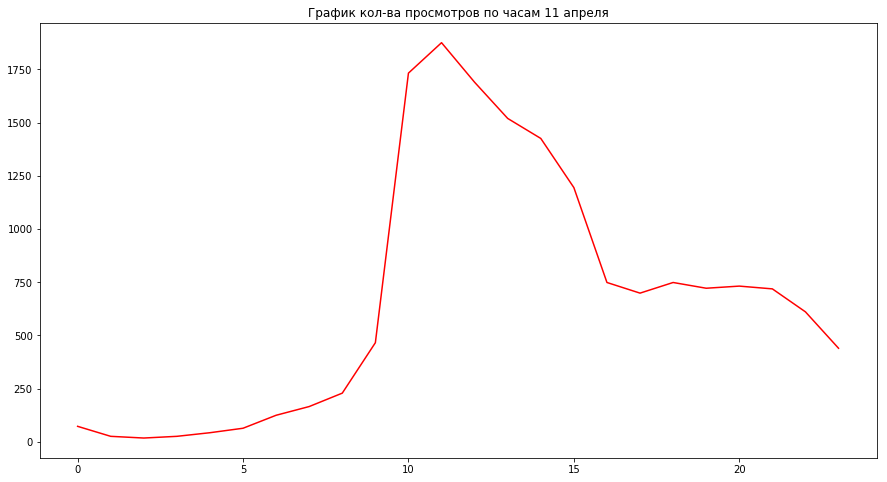

In [13]:
plt.figure(figsize = (15, 8))
plt.title('График кол-ва просмотров по часам 11 апреля')
plt.plot(by_hour, color = 'red', linestyle = '-')

Сравним с почасовым графиком за 10 апреля

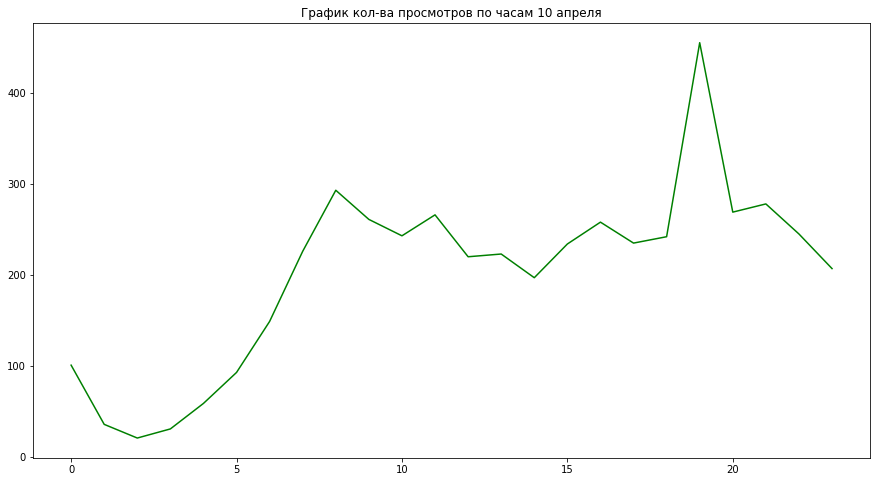

In [14]:
data_view_0410 = data[(data['time'] >= '2019-04-10 00:00:00') & (data['time'] < '2019-04-11 00:00:00') &  (data['event'] == 'view')]
by_hour_10 = data_view_0410.groupby(by = data_view_0410['time'].dt.hour)['event'].count()
plt.figure(figsize = (15, 8))
plt.title('График кол-ва просмотров по часам 10 апреля')
plt.plot(by_hour_10, color = 'green', linestyle = '-')

Заметна аномалия в период с 10 до 15 часов 11 апреля (если подумать, то интуитивно такие значения в такое время действительно выглядят странно, так как обычно в это время люди реже пользуются соцсетями, так как находятся на работе/учебе)

Давайте развернем данные в промежутке с 9 до 15 часов 11 апреля

In [15]:
data_view_0915 = data[(data['time'] >= '2019-04-11 09:00:00') & (data['time'] < '2019-04-11 16:00:00') &  (data['event'] == 'view')]

Взглянем на данные

In [16]:
data_view_0915.head(10)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
22,2019-04-11 10:08:03,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11
43,2019-04-11 11:15:49,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11
44,2019-04-11 11:37:40,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11
47,2019-04-11 14:42:32,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-11
48,2019-04-11 11:59:18,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-11
53,2019-04-11 10:50:03,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11
55,2019-04-11 09:08:42,view,CPC,0,no_agency,client_37,campaign_4387,ad_4744,android,2019-04-11
60,2019-04-11 14:09:37,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11
76,2019-04-11 11:02:22,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-11
89,2019-04-11 13:08:32,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11


Видно, что почти все показы - от одного клиента

Идентификатор кампании - один и тот же

Давайте посмотрим статистики, действительно ли большая часть объявлений была от одного клиента

In [17]:
data_view_0915['campaign_union_id'].value_counts()[:5]

campaign_49554    8884
campaign_387        70
campaign_99242      46
campaign_47269      37
campaign_5822       31
Name: campaign_union_id, dtype: int64

In [18]:
data_view_0915[data_view_0915['campaign_union_id'] == 'campaign_49554']['ad_id'].value_counts()[:5]

ad_49554    6288
ad_49556    2201
ad_49560     244
ad_49564     151
Name: ad_id, dtype: int64

И действительно, заметен огромный неестественный выброс. Разница почти в 150 раз!

Выброс случился из-за объявления ad_49554, количество его показов стало слишком большим

А еще видно, что тип объявления - CPC, то есть рекламодатель платит за клик, за показы не платит

Но что же является причиной такого выброса? Давайте разбираться.

In [19]:
data_view_0915[data_view_0915['campaign_union_id'] == 'campaign_49554']['platform'].value_counts()

android    6245
iphone     1092
web         886
mvk         661
Name: platform, dtype: int64

In [20]:
campaign_data = data[data['campaign_union_id'] == 'campaign_49554']

In [21]:
print(campaign_data[campaign_data['ad_id'] == 'ad_49554'].sort_values('time')['time'].head(1))
print(campaign_data[campaign_data['ad_id'] == 'ad_49554'].sort_values('time')['time'].tail(1))

8702   2019-04-10 18:52:31
Name: time, dtype: datetime64[ns]
117612   2019-04-16 18:48:39
Name: time, dtype: datetime64[ns]


Первая дата появления объявления - 10 апреля, 18:52, последний показ - 16 апреля, 18:48

Разобьем данные по этому объявлению на 5-минутные интервалы

In [22]:
data_view_0915.index = data_view_0915.time

In [23]:
campaign_49554 = data_view_0915[data_view_0915['campaign_union_id'] == 'campaign_49554'].sort_index()
five_minute_intervals = data_view_0915.groupby(pd.TimeGrouper('5Min'))['event'].count()
five_minute_campaign = campaign_49554.groupby(pd.TimeGrouper('5Min'))['event'].count()

C:\Users\DFursov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\Users\DFursov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until


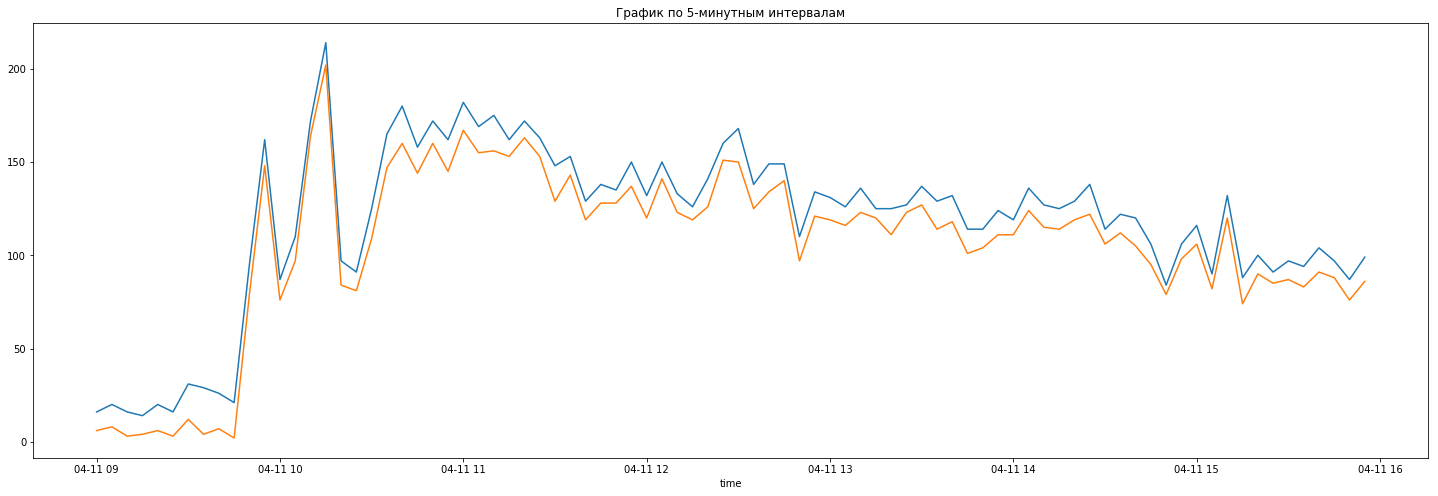

In [24]:
plt.figure(figsize = (25, 8))
plt.title('График по 5-минутным интервалам')
sns.lineplot(x = five_minute_intervals.index, y = five_minute_intervals.values)
sns.lineplot(x = five_minute_campaign.index, y = five_minute_campaign.values)

Из этого графика хорошо видно, что практически все объявления, которые показывались пользователям, принадлежат именно этой рекламной кампании

In [25]:
five_minute_campaign.sort_index()[:30]

time
2019-04-11 09:00:00      6
2019-04-11 09:05:00      8
2019-04-11 09:10:00      3
2019-04-11 09:15:00      4
2019-04-11 09:20:00      6
2019-04-11 09:25:00      3
2019-04-11 09:30:00     12
2019-04-11 09:35:00      4
2019-04-11 09:40:00      7
2019-04-11 09:45:00      2
2019-04-11 09:50:00     79
2019-04-11 09:55:00    148
2019-04-11 10:00:00     76
2019-04-11 10:05:00     97
2019-04-11 10:10:00    164
2019-04-11 10:15:00    202
2019-04-11 10:20:00     84
2019-04-11 10:25:00     81
2019-04-11 10:30:00    109
2019-04-11 10:35:00    147
2019-04-11 10:40:00    160
2019-04-11 10:45:00    144
2019-04-11 10:50:00    160
2019-04-11 10:55:00    145
2019-04-11 11:00:00    167
2019-04-11 11:05:00    155
2019-04-11 11:10:00    156
2019-04-11 11:15:00    153
2019-04-11 11:20:00    163
2019-04-11 11:25:00    153
Freq: 5T, Name: event, dtype: int64

### Выводы

Причиной резкого выброса в данных является рекламная кампания 49554, начиная с 09:50 11.04 объявление стало показываться очень большому количеству людей (объявление ad_49554 показывалось значительно больше других из кампании).

Что показалось странным:

- объявление из кампании значительно чаще показывается пользователям на платформе Android (хотя по статистике, которую я знаю, пользователей Android в 2.5 раза больше, но не в 6)

- формат объявления - CPC, но при этом огромное количество показов (а кликов было совсем немного относительно количества показов)


#### Возможные гипотезы:

- произошло некое событие, о котором люди стали массово писать в соцсети, что привело к резкому расширению потенциального охвата этого объявления, которое имело таргет на соответствующие слова;
- владелец объявления ошибся и залил большую денежную сумму, при этом выставив слишком большую награду за клик, что повлекло огромный рост показов его объявления